In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time # To measure training time

from cleaning_and_preprocessing_function import clean_n_preprocess
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [2]:
df = pd.read_csv("./../dataset/port_operations_log.csv")
X = df.drop(columns=['Actual_Operation_Duration_Hours'])
y = df['Actual_Operation_Duration_Hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = clean_n_preprocess(X_train)
X_test = clean_n_preprocess(X_test)

In [3]:
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# --- 1. Define Models and Parameter Grids for GridSearchCV ---

# Common scoring metric for GridSearchCV
# want to minimize error, so using 'neg_mean_absolute_error' or 'neg_mean_squared_error'
# Higher (less negative) is better. R2 is also an option.
# use MAE as it's easily interpretable in hours.
scoring_metric = 'neg_mean_absolute_error' # GridSearchCV maximizes this score

# a) Decision Tree Regressor
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'absolute_error'] 
}
dt_model = DecisionTreeRegressor(random_state=42)

# b) Random Forest Regressor
rf_param_grid = {
    'n_estimators': [50, 100, 150], # Fewer for faster grid search, increase for better performance
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None] 
}
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1) # Use all cores

# c) Gradient Boosting Regressor
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0] # Fraction of samples to be used for fitting individual base learners
}
gb_model = GradientBoostingRegressor(random_state=42)

models_and_grids = {
    'Decision Tree': (dt_model, dt_param_grid),
    'Random Forest': (rf_model, rf_param_grid),
    'Gradient Boosting': (gb_model, gb_param_grid)
}

# --- 2. Perform Hyperparameter Tuning with GridSearchCV ---
best_estimators = {}
cv_results_summary = {}
training_times = {}

for model_name, (model, param_grid) in models_and_grids.items():
    print(f"\n--- Tuning {model_name} ---")
    start_time = time.time()
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=5, # 5-fold cross-validation
                               scoring=scoring_metric,
                               verbose=1, # Set to 0 for less output, 2 for more
                               n_jobs=-1) # Use all available cores

    grid_search.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    training_times[model_name] = train_time

    best_estimators[model_name] = grid_search.best_estimator_
    cv_results_summary[model_name] = pd.DataFrame(grid_search.cv_results_) # Store all CV results

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best CV {scoring_metric.replace('neg_', '')}: {-grid_search.best_score_:.4f}") # Make score positive
    print(f"Training time for {model_name}: {train_time:.2f} seconds")

Training set shape: X_train=(4000, 23), y_train=(4000,)
Test set shape: X_test=(1000, 23), y_test=(1000,)

--- Tuning Decision Tree ---
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters for Decision Tree: {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV mean_absolute_error: 9.9847
Training time for Decision Tree: 65.85 seconds

--- Tuning Random Forest ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best CV mean_absolute_error: 9.3484
Training time for Random Forest: 208.15 seconds

--- Tuning Gradient Boosting ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.7}
Best CV mean_absolute_error: 9.2038
Training time for Gr

In [4]:
# --- 4. More Sophisticated Model Evaluation ---
evaluation_results = []

print("\n\n--- Final Model Evaluation on Test Set ---")
for model_name, best_model in best_estimators.items():
    print(f"\n--- Evaluating {model_name} ---")
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f} hours")
    print(f"RMSE: {rmse:.4f} hours")
    print(f"R-squared: {r2:.4f}")

    evaluation_results.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Training Time (s)': training_times[model_name]
    })

evaluation_df = pd.DataFrame(evaluation_results)
print("\n--- Evaluation Summary Table ---")
print(evaluation_df.sort_values(by='MAE')) # Sort by MAE, lower is better



--- Final Model Evaluation on Test Set ---

--- Evaluating Decision Tree ---
MAE: 9.7807 hours
RMSE: 14.1044 hours
R-squared: 0.9560

--- Evaluating Random Forest ---
MAE: 8.9665 hours
RMSE: 12.7297 hours
R-squared: 0.9642

--- Evaluating Gradient Boosting ---
MAE: 9.0041 hours
RMSE: 12.9752 hours
R-squared: 0.9628

--- Evaluation Summary Table ---
               Model       MAE       RMSE        R2  Training Time (s)
1      Random Forest  8.966524  12.729746  0.964170         208.151485
2  Gradient Boosting  9.004135  12.975237  0.962775         224.286751
0      Decision Tree  9.780684  14.104372  0.956014          65.847150


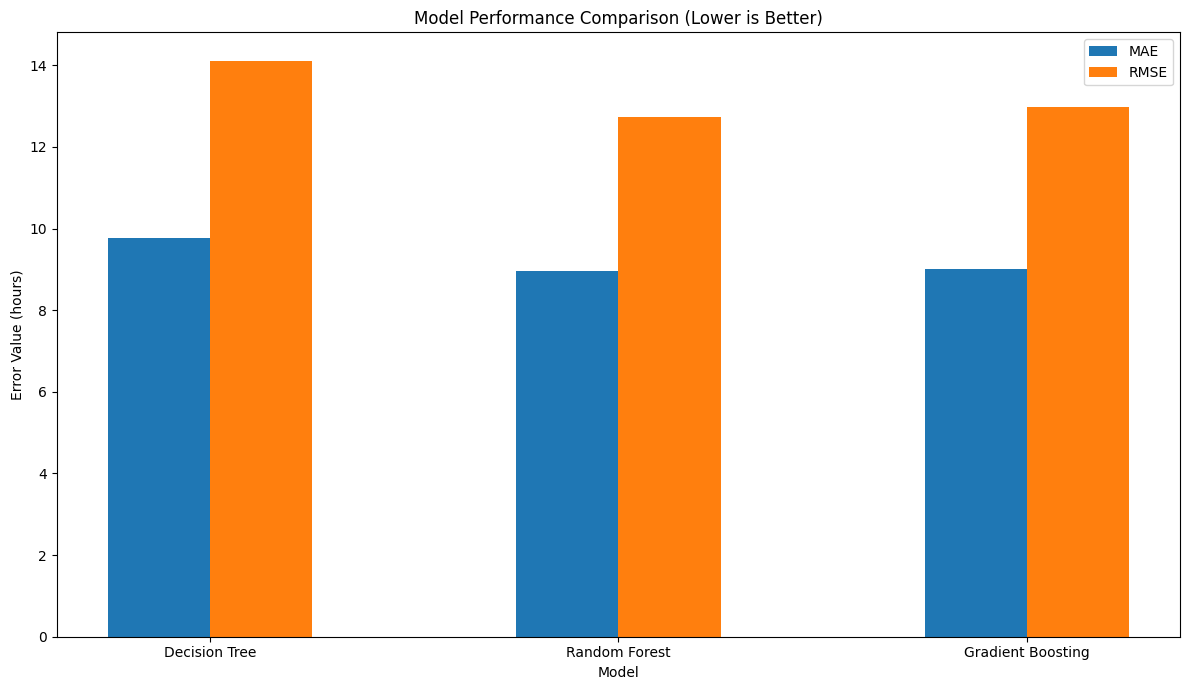

C:\Users\huiqi\AppData\Local\Temp\ipykernel_2844\943091587.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=evaluation_df.sort_values('R2', ascending=False), palette='viridis')


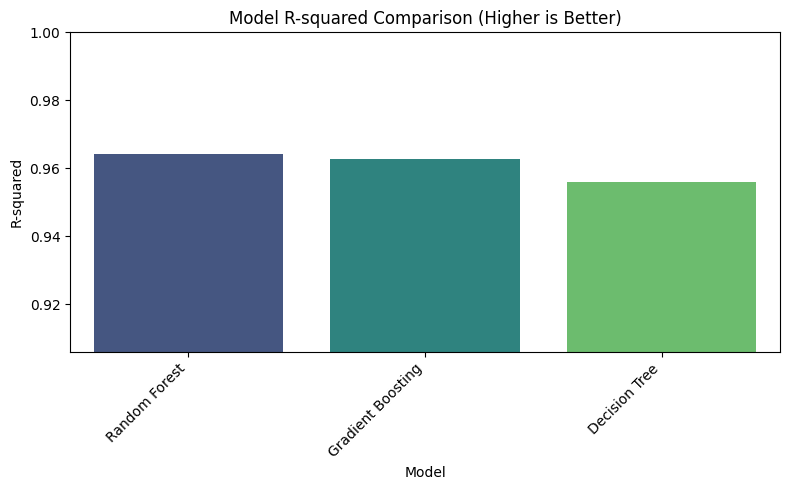

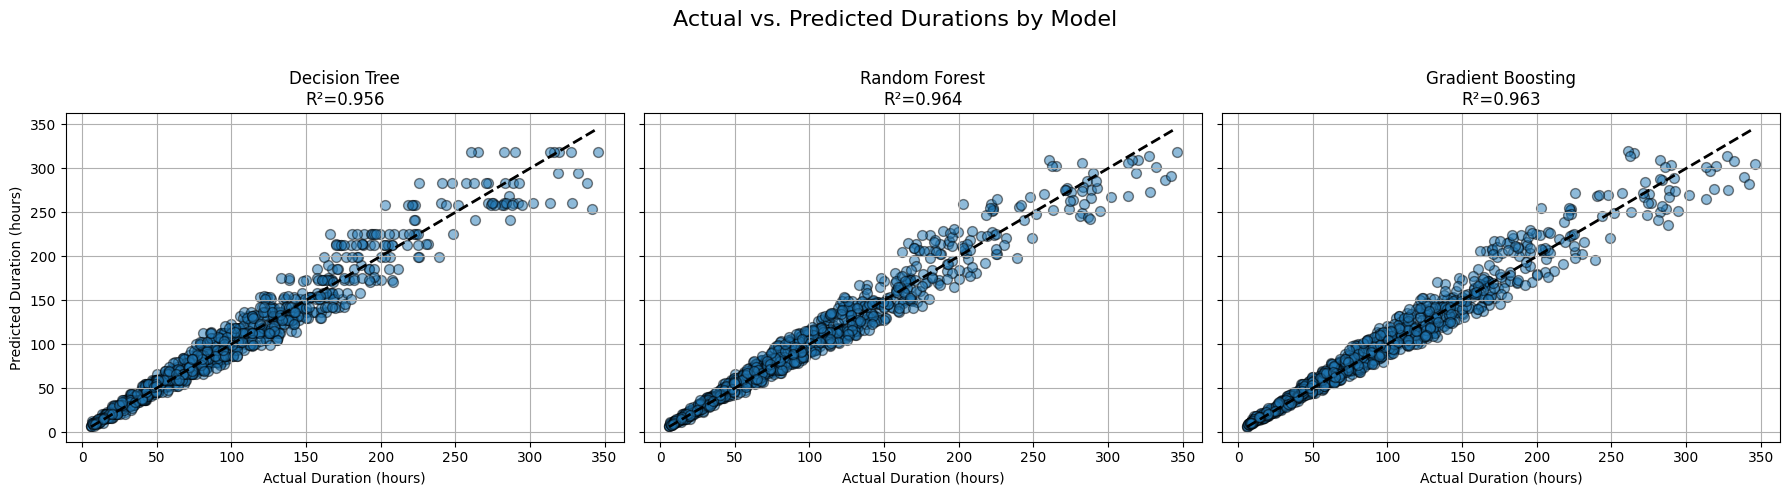

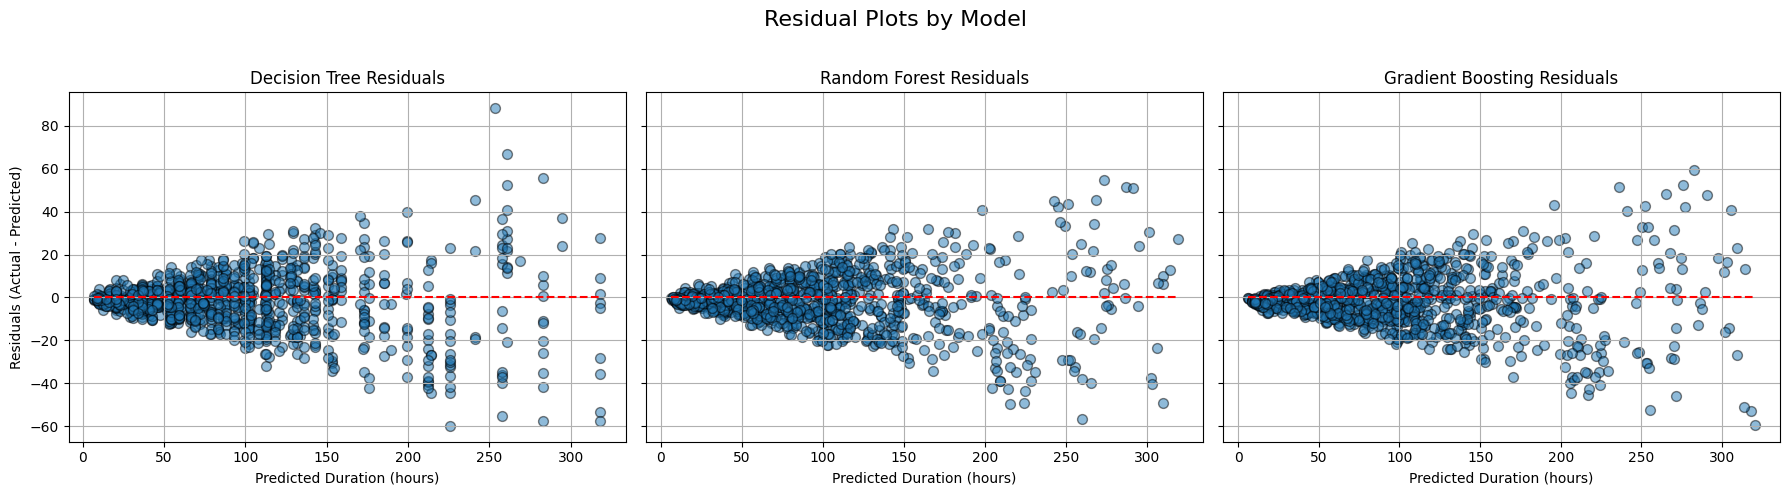

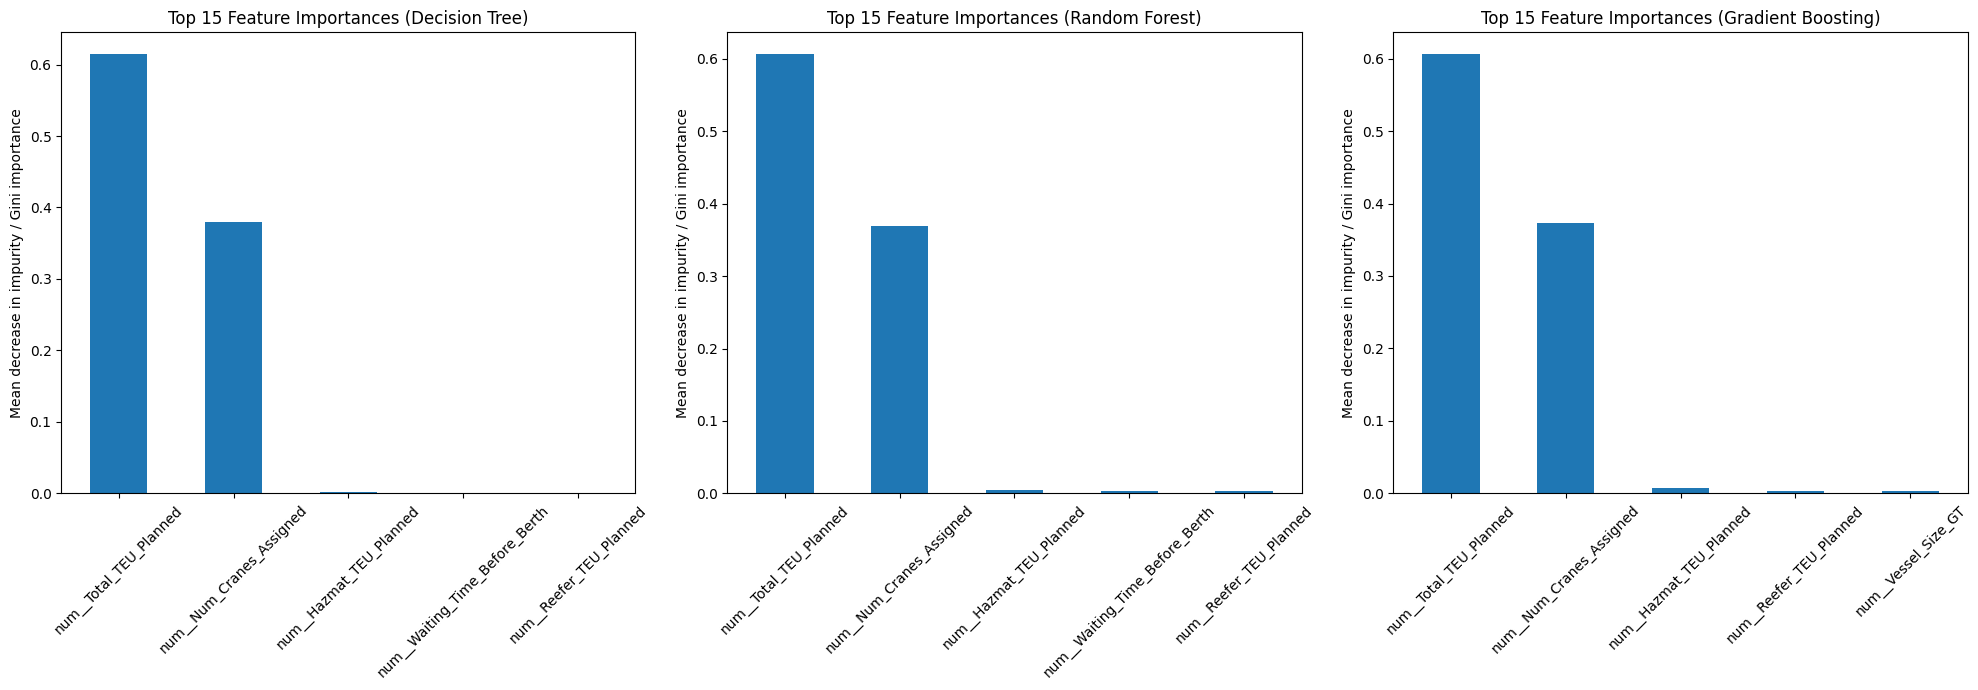

In [6]:
# --- 5. Creating Relevant Figures and Tables ---

# a) Performance Comparison Bar Chart
plt.figure(figsize=(12, 7))
metrics_to_plot = ['MAE', 'RMSE']
n_metrics = len(metrics_to_plot)
bar_width = 0.25
index = np.arange(len(best_estimators))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(index + i * bar_width, evaluation_df[metric], bar_width, label=metric)

plt.xlabel('Model')
plt.ylabel('Error Value (hours)')
plt.title('Model Performance Comparison (Lower is Better)')
plt.xticks(index + bar_width * (n_metrics -1 ) / 2, evaluation_df['Model'])
plt.legend()
plt.tight_layout()
plt.show()

# b) R-squared Bar Chart (Higher is better)
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2', data=evaluation_df.sort_values('R2', ascending=False), palette='viridis')
plt.title('Model R-squared Comparison (Higher is Better)')
plt.ylabel('R-squared')
plt.ylim(max(0, evaluation_df['R2'].min() - 0.05), min(1, evaluation_df['R2'].max() + 0.05)) # Adjust y-limits
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# c) Actual vs. Predicted Scatter Plots
fig, axes = plt.subplots(1, len(best_estimators), figsize=(18, 5), sharey=True)
if len(best_estimators) == 1: # Handle single model case for axes indexing
    axes = [axes]

for i, (model_name, best_model) in enumerate(best_estimators.items()):
    y_pred_scatter = best_model.predict(X_test)
    ax = axes[i]
    ax.scatter(y_test, y_pred_scatter, alpha=0.5, edgecolors='k', s=50)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Perfect prediction line
    ax.set_xlabel('Actual Duration (hours)')
    if i == 0:
        ax.set_ylabel('Predicted Duration (hours)')
    ax.set_title(f'{model_name}\nR²={r2_score(y_test, y_pred_scatter):.3f}')
    ax.grid(True)

plt.suptitle('Actual vs. Predicted Durations by Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

# d) Residual Plots (Error distribution)
fig, axes = plt.subplots(1, len(best_estimators), figsize=(18, 5), sharey=True)
if len(best_estimators) == 1:
    axes = [axes]

for i, (model_name, best_model) in enumerate(best_estimators.items()):
    y_pred_residuals = best_model.predict(X_test)
    residuals = y_test - y_pred_residuals
    ax = axes[i]
    ax.scatter(y_pred_residuals, residuals, alpha=0.5, edgecolors='k', s=50)
    ax.hlines(0, xmin=y_pred_residuals.min(), xmax=y_pred_residuals.max(), colors='red', linestyles='--')
    ax.set_xlabel('Predicted Duration (hours)')
    if i == 0:
        ax.set_ylabel('Residuals (Actual - Predicted)')
    ax.set_title(f'{model_name} Residuals')
    ax.grid(True)

plt.suptitle('Residual Plots by Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# e) Feature Importances (for tree-based models)
if hasattr(best_estimators.get('Random Forest'), 'feature_importances_') or \
   hasattr(best_estimators.get('Gradient Boosting'), 'feature_importances_') or \
   hasattr(best_estimators.get('Decision Tree'), 'feature_importances_'):

    fig, axes = plt.subplots(1, len(best_estimators), figsize=(20, 7)) # Adjust as needed
    if len(best_estimators) == 1:
      axes = [axes]

    plot_index = 0
    for model_name, best_model in best_estimators.items():
        if hasattr(best_model, 'feature_importances_'):
            ax = axes[plot_index]
            importances = best_model.feature_importances_
            # Get feature names from X_train (which should match X_processed_df columns)
            feature_names = X_train.columns
            forest_importances = pd.Series(importances, index=feature_names)
            sorted_importances = forest_importances.sort_values(ascending=False).head(5) # Top 5

            sorted_importances.plot.bar(ax=ax)
            ax.set_title(f"Top 15 Feature Importances ({model_name})")
            ax.set_ylabel("Mean decrease in impurity / Gini importance") # Or MDI for RF/GB
            ax.tick_params(axis='x', rotation=45)
            plot_index += 1

    # Remove any unused subplots if not all models have feature importances
    for i in range(plot_index, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()